In [1]:
!kaggle datasets download -d anaselmasry/data-augmantation-covid

data-augmantation-covid.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip -q data-augmantation-covid.zip

replace Covid-19/covid_0_1000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
IMAGE_SIZE = 224


def load_images(folder, label):
  paths = glob(folder + '/*.jpg')
  images = []
  for path in paths:
    img = Image.open(path)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    images.append(np.array(img))
  return np.array(images), [[label] for _ in range(len(images))]


x1, y1 = load_images('Covid-19', 1)
x2, y2 = load_images('Non-Covid-19', 0)
images = np.concatenate([x1, x2])
labels = np.concatenate([y1, y2])
print('images: ', images.shape)
print('labels: ', labels.shape)
assert len(labels) == len(images)

images:  (2762, 224, 224, 3)
labels:  (2762, 1)


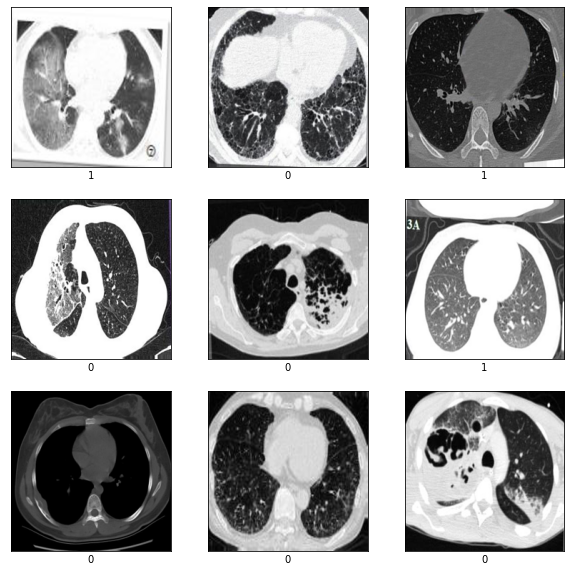

In [3]:
plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  index = np.random.randint(0, len(images))
  plt.imshow(images[index, :, :, :])
  plt.xlabel(str(labels[index, 0]))
plt.show()

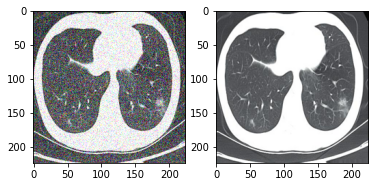

In [4]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

def add_random_noise(image, label):
  noise = tf.stop_gradient(tf.random.normal(tf.shape(image), mean=0.0, stddev=0.16))
  return tf.clip_by_value(image + noise, 0.0, 1.0), image

dataset = tf.data.Dataset.from_tensor_slices((images, labels)).map(normalize).map(add_random_noise)

for pair in dataset:
  sample_image, sample_label = pair
  plt.subplot(1, 2, 1)
  plt.imshow(sample_image)
  plt.subplot(1, 2, 2)
  plt.imshow(sample_label)
  plt.show()
  break

In [5]:
def inference(x):
  downsampling = [32, 64, 128, 256]
  features = []
  for d in downsampling:
    for _ in range(3):
      x = keras.layers.Conv2D(d, 3, 1, padding='same', activation='relu')(x)
    features = [x] + features
    x = keras.layers.MaxPool2D(3, strides=2, padding='same')(x)
  for _ in range(3):
    x = keras.layers.Conv2D(d, 3, 1, padding='same', activation='relu')(x)
  upsampling = downsampling[::-1]
  for i, u in enumerate(upsampling):
    x = keras.layers.UpSampling2D()(x)
    for _ in range(3):
      x = keras.layers.Conv2D(u, 3, 1, padding='same', activation='relu')(x)
    x = keras.layers.Add()([x, features[i]])
  x = keras.layers.Conv2D(3, 3, 1, padding='same')(x)
  return x


def create_model():
  inputs = keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  output = inference(inputs)
  model = keras.Model(inputs=[inputs], outputs=[output])
  optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
  model.compile(optimizer=optimizer, loss='mean_squared_error')
  return model

keras.backend.clear_session()
model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        conv2d_1[0][0]                   
_______________________________________________________________________________________

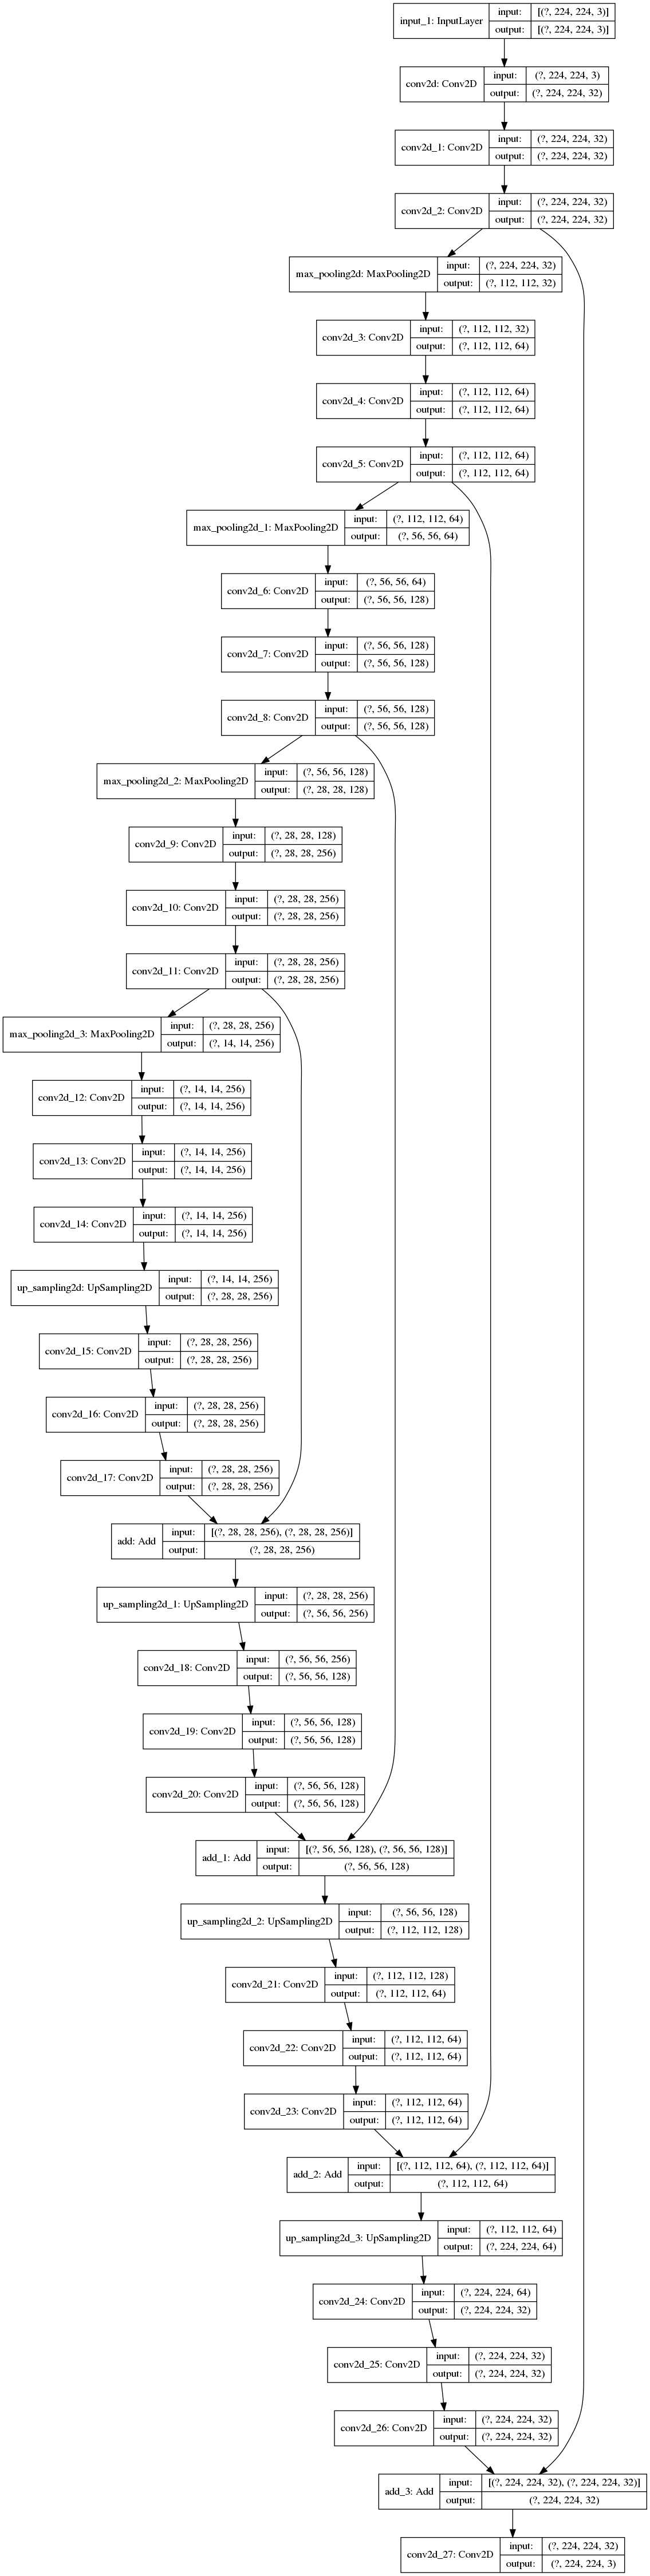

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='autoencoder_encoder.png')

In [7]:
BATCH_SIZE = 32

train_size = int(len(images) * 0.8)
train_ds = dataset.take(train_size).shuffle(100).batch(BATCH_SIZE).repeat()
test_ds = dataset.skip(train_size).take(len(images) - train_size).batch(BATCH_SIZE)

print(train_ds)
print(test_ds)

<RepeatDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3)), types: (tf.float32, tf.float32)>


In [9]:
def scheduler(epoch, lr):
  if epoch == 10:
    return 1e-5
  elif epoch == 20:
    return 3e-6
  return lr


history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=30,
                    steps_per_epoch=500,
                    callbacks=[keras.callbacks.LearningRateScheduler(scheduler, verbose=True)])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 1/30
500/500 [==============================] - 175s 350ms/step - loss: 0.0383 - val_loss: 0.0089

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 2/30
500/500 [==============================] - 173s 346ms/step - loss: 0.0025 - val_loss: 0.0021

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 3/30
500/500 [==============================] - 173s 346ms/step - loss: 0.0020 - val_loss: 0.0021

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 4/30
500/500 [==============================] - 171s 343ms/step - loss: 0.0018 - val_loss: 0.0017

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
Epoch 5/30
500/500 [==============================] - 172s 343ms/step - loss: 0.0016 - val_loss: 0.0015

Epoch 00006: LearningRateScheduler reducing learn

In [8]:
model.load_weights('noise_removal2.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


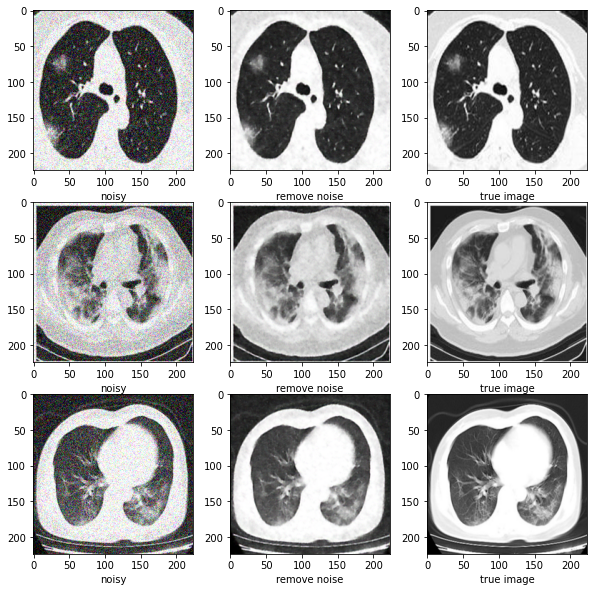

In [10]:
for batch in train_ds:
  noisy_image, true_image = batch
  remove_noise = model.predict(noisy_image)
  plt.figure(figsize=(10, 10))
  for i in range(3):
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(noisy_image[i, ...])
    plt.xlabel('noisy')
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(remove_noise[i, ...])
    plt.xlabel('remove noise')
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(true_image[i, ...])
    plt.xlabel('true image')
  plt.show()
  break

In [11]:
model.save('noise_removal2.h5')